# 지원동기 대신 써주는 프로그램

In [11]:
from bs4 import BeautifulSoup
from downloads import *
import requests
import time
import urllib
import os
from nltk.probability import FreqDist
from NLP import * 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import re
import matplotlib.font_manager as fm
import ngram
font_setting()

# Input

In [ ]:
q=input("지원하시는 회사의 이름을 기재해주세요\t")
q2=input("지원하는 회사의 직무를 기재해주세요\t")
try:
    p=int(input("몇 페이지까지 검색할까요?\t\t"))
except:
    p=10
q3=input("공고에 직무에 대한 설명이 있다면 키워드 중심으로 같이 써주세요(없을 시 공란으로 두세요)\t")

In [146]:
naver=BeautifulSoup(download("https://search.naver.com/search.naver?",params={"query":q}).text,"lxml")
company_official_name=naver.select_one(".sp_company .main_title").text
company_name=[_.text for _ in naver.select(".nsite dt a")][0]
company_link=[_.text for _ in naver.select(".nsite dt a")][1].replace("www.","").replace(".com","")

In [147]:
company_official_name,company_name

('삼성생명보험', '삼성생명')

In [148]:
print("{0}에 입사하게 된다면 최고의 {1} 전문가가 되도록 언제나 노력하겠습니다".format(company_official_name,q2))

삼성생명보험에 입사하게 된다면 최고의 디지털 전문가가 되도록 언제나 노력하겠습니다


# Crawling

In [149]:
def clean_title(title,q):
    if q in title:
        title = title.replace(q,"")
    pattern = re.compile("\[.*\]")
    if pattern.search(title):
        title = pattern.sub("",title)
    return title

In [150]:
news_list=[]
for page in range(1,p+1):
    url=download("https://search.daum.net/search",params={"w":"news","q":q+" "+q2,"cluster":"y","p":str(page)})
    dom=BeautifulSoup(url.text,"lxml")
    news_list+=[(_["href"], clean_title(_.text,q)) for _ in dom.select("article .wrap_tit.mg_tit a")]

In [151]:
news_list

[('https://cp.news.search.daum.net/p/79756322', '도입 6개월만에 안착 연 2만4000시간 ...'),
 ('http://v.media.daum.net/v/20190417143329712?f=o',
  '로봇에 업무 맡기니 2만 시간 절약..의 디지털 혁신'),
 ('http://v.media.daum.net/v/20190417101206118?f=o', ', RPA 정착으로 디지털혁신 가속화'),
 ('https://cp.news.search.daum.net/p/78534934', ' 현성철號, 디지털혁신 성과 가시화'),
 ('http://v.media.daum.net/v/20190417182112681?f=o', ', 로봇 프로세스 자동화로 업무시간 단축'),
 ('http://v.media.daum.net/v/20190515092102660?f=o',
  ', 1분기 순익 4473억원..전년 대비 14.7%↑'),
 ('https://cp.news.search.daum.net/p/79811253',
  '"우리가 남이가?" , 삼성전자-제일기획 팔고 ‘삼성바이오...'),
 ('http://v.media.daum.net/v/20190509083900768?f=o',
  ' "생명사랑 릴레이로 자살 예방 기부하세요"'),
 ('https://cp.news.search.daum.net/p/78542156', ', RPA 정착...연 2만4천시간 절약'),
 ('https://cp.news.search.daum.net/p/78532522',
  ', ‘PRA 프로젝트’ 6개월...연간 2만4000시간 절약'),
 ('http://v.media.daum.net/v/20190523175101996?f=o',
  '"파괴적 혁신하려면 금융 - 핀테크社 협업해야"'),
 ('http://v.media.daum.net/v/20190507103000743?f=o',
  ", 총 5000만원 상금 '제1회 전국 탁구클럽 대축제' 개최

In [152]:
# clean_title(title[0],q)

In [153]:
# textdistance.hamming.normalized_similarity("안녕", "안녕")

In [154]:
# title=[title for link,title in news_list]
# dist=[]
# # import textdistance
# # for i in range(len(title)):
# #     for _ in title[i:]:
# #         dist=textdistance.hamming.normalized_similarity(clean_title(_,q),clean_title(title[i],q))
# #         print(dist)
# #         if dist>0 and dist<1:
# #             print(title[i],dist,_)
# #             title[i]=np.nan

# # textdistance.hamming('text', 'test')
# # textdistance.hamming.normalized_similarity('text', 'test')
# # textdistance.hamming('arrow', 'arow')textdistance.hamming.normalized_similarity('arrow', 'arow')

In [155]:
# news_list=pd.DataFrame({"title":title,"link":[link for link,_ in news_list]}).dropna().reset_index().drop("index",1)

In [156]:
# for link, title in news_list:
#     url = download(link)
#     dom = BeautifulSoup(url.text,"lxml")
#     if dom.select("#articletxt"): # 한국 경제
#         print([_.text for _ in dom.select("#articletxt")])
#     elif dom.select("#articleBody p"):# 아이뉴스 
#         print(dom.select("#articleBody p"))
#     elif dom.select("#divNewsContent"):
#         print([_.text for _ in dom.select("#divNewsContent")])
#     elif dom.select("#articleText"):
#         print([_.text for _ in dom.select("#articleText")]) # 헤럴드경제
#     elif dom.select("#articleBody"):
#         print([_.text for _ in dom.select("#articleBody")]) # 전자신문

## 링크 타고들어가서 뉴스 가져오기 : re사용

In [157]:
css_codes = ["[class*=['news']]"]

In [158]:
css_codes = ["[class*='news']","[class*='body']","[class*='article']"]

In [159]:
# news=[]
# for link,title in news_list:
#     print(link)
#     url = download(link)
#     dom = BeautifulSoup(url.text,"lxml")
#     for css in css_codes:
#         if dom.select(css):
#             print(css)
#             news+=[[_.text for _ in dom.select(css)]]
#             break

In [160]:
news = []
for link,_ in news_list:
    url = download(link)
    dom = BeautifulSoup(url.text,"lxml")
    for css in css_codes:
        if dom.select(css):
            news += [[_.text for _ in dom.select(css)]]
            break

# get keyword

In [161]:
from collections import Counter
from nltk import Text
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import gutenberg
import os
import matplotlib.pyplot as plt
from math import log 
import re
from konlpy.tag import Okt
from konlpy.tag import Kkma # JVM 에서 가져오는 거라서 한번만 돌리는게 좋음
from konlpy.corpus import kolaw,kobill
from downloads import *
from get_corpus import *
from string import punctuation
from NLP import *

In [162]:
okt = Kkma()
q2_token = okt.pos(q)
query_list = [okt.pos(q)[0][0], okt.pos(q2)[0][0]]

In [163]:
find_keyword = [_.strip() for artcl in news for sen in artcl for _ in sen.split(".") if q2 in _ ]

In [164]:
query_list

['삼성생명', '디지털']

## keyword cleansing : 그룹사, 다른이름 빼기

In [165]:
def split_sub(name):
    pttn=re.compile("[A-z]+")
    if pttn.search(name):
        return pttn.search(name)[0],pttn.sub("",name)
    else:
        return ''

In [166]:
split_sub(company_official_name)

''

In [167]:
company_official_name,company_link

('삼성생명보험', 'samsunglife')

In [168]:
query_list+=[company_official_name,company_name,split_sub(company_official_name),split_sub(company_name)]

In [169]:
query_list = [_ for _ in unique(query_list) if _ != ""] 

In [170]:
query_list

['디지털', '삼성생명', '삼성생명보험']

In [171]:
for _ in range(2,len(q)):
    query_list+=ngram.umjeol(q,_)

In [172]:
query_list=[_.lower() for _ in query_list]

In [173]:
query_list=[_ for q in query_list for _ in q.split(" ")]

In [174]:
query_list

['디지털', '삼성생명', '삼성생명보험', '삼성', '성생', '생명', '삼성생', '성생명']

## find keyword  : preprocessing

In [175]:
find_keyword=[_.lower() for _ in find_keyword]

In [176]:
pattern=re.compile("(^NN)|OL")

In [177]:
freq=FreqDist([_ for keyword in find_keyword for _ in okt.pos(keyword) if _[0] not in query_list])

In [ ]:
freq

In [138]:
freq=FreqDist([_ for keyword in find_keyword for _ in okt.pos(keyword) if _[0] not in query_list and len(_[0])>1 and pattern.search(_[1])])

In [139]:
freq

FreqDist({('카레', 'NNG'): 65, ('제품', 'NNG'): 24, ('소비자', 'NNG'): 23, ('시장', 'NNG'): 21, ('다양', 'NNG'): 20, ('출시', 'NNG'): 20, ('업계', 'NNG'): 19, ('요리', 'NNG'): 18, ('활용', 'NNG'): 16, ('언서', 'NNG'): 16, ...})

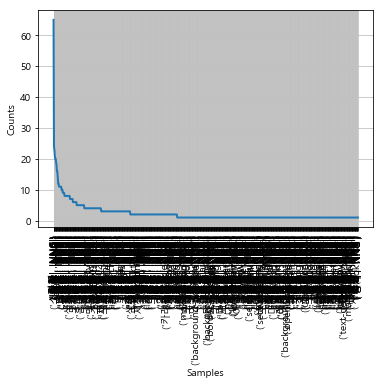

In [129]:
freq.plot()

# 시각화

In [130]:
plt.rcParams.update({'font.size': 10, 'figure.figsize':(14,12)})

In [131]:
# x=np.random.sample(len(freq))
# y=np.random.sample(len(freq))
# mean_freq=np.array(list(map(int,freq.values()))).mean()
# ax=sns.scatterplot(x,y,s=list(map(lambda e: e**2,freq.values())),alpha=0.5)
# for key,value in enumerate(freq):
#     if freq[value]>mean_freq:
#         ax.text(x[key], y[key], value[0], horizontalalignment='left', size='medium', color='black', weight='semibold')

In [132]:
!pip install wordcloud

In [133]:
from wordcloud import WordCloud

In [142]:
for_cld = FreqDist([_[0] for keyword in find_keyword for _ in okt.pos(keyword) if pattern.search(_[1]) and _[0] not in query_list and len(_[0])>1])
# for_cld = FreqDist([_[0] for _ in freq])

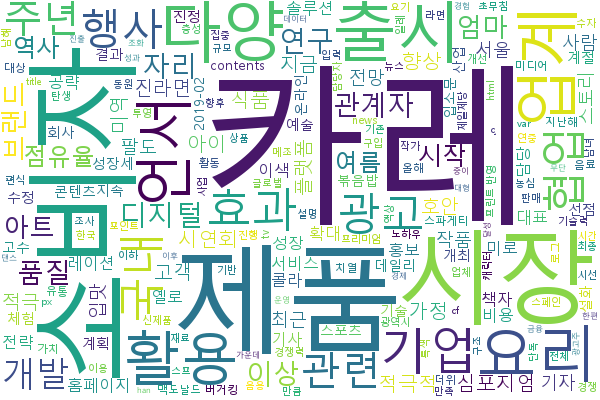

In [143]:
cld = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",width=600,height=400,background_color='white')
cld.generate_from_frequencies(for_cld).to_image()

## 특이한 단어를 뽑아낼 필요성을 느낌 : TF-IDF 해보기

In [259]:
import pickle

In [1]:
from bad_at_io import *

In [5]:
def ld():
    return defaultdict(int)

In [8]:
TDM = pickle_open("TDM.pickle")

In [10]:
for term in find_:
    if 

defaultdict(<function __main__.ld()>,
            {'이송/NNP': defaultdict(int,
                         {"'KT 채용비리 수": 1,
                          "'명예훼손 피소' ": 1,
                          "'사기 당했다는데'": 1,
                          "'역시나' 극적 합": 1,
                          "'이란 압박' 미국": 1,
                          "'차세대 지능형 반": 1,
                          "10년 미스터리 '": 1,
                          'KT새노조 "KT채': 1,
                          'WP "트럼프·김정': 1,
                          '[인사] 에너지경제': 1,
                          '[인사] 우정사업본': 1,
                          '[취임2주년 대담]': 2,
                          '中, 관세인상 보복': 1,
                          '中상무부 "美 추가': 1,
                          '文대통령 "검찰 셀': 1,
                          "文대통령 '5월 여": 1,
                          '美 항모 이어 패트': 1,
                          '美, 對中 관세율 ': 1,
                          '美, 무역협상중 2': 1,
                          '靑 "대통령-여야 ': 1,
                          '韓美, 北미사일에도': 1,
                   

In [261]:
normal_words = [__ for _ in data for __ in _ if pattern.search(__[1])]

In [262]:
normal_dist = FreqDist(normal_words)

In [263]:
tfidf_dict = FreqDist()
for key in freq.keys():
    if key in normal_dist.keys():
        tfidf_dict[key] = freq.get(key)/normal_dist.get(key)
    else:
        tfidf_dict[key] = freq[key]

In [264]:
mean_freq=np.array(list(map(int,tfidf_dict.values()))).mean()

In [265]:
freq

FreqDist({('분석', 'NNG'): 104, ('주가', 'NNG'): 68, ('기업', 'NNG'): 65, ('분기', 'NNG'): 54, ('가치', 'NNG'): 52, ('점수', 'NNG'): 49, ('예상', 'NNG'): 48, ('데이터', 'NNG'): 48, ('상장', 'NNG'): 45, ('결과', 'NNG'): 40, ...})

In [ ]:
# ax = sns.scatterplot(x,y,s = list(map(lambda e: e**3,tfidf_dict.values())),alpha = 0.5)
# for key,value in enumerate(tfidf_dict):
#     if tfidf_dict[value]>mean_freq:
#         ax.text(x[key], y[key], value[0], horizontalalignment = 'left', size = 'medium', color = 'black', weight = 'semibold', )

망함..

In [140]:
query_list

['SKT',
 'AI',
 'sk',
 'kt',
 ['SK텔레콤'],
 'SK telecom',
 'www.sktelecom.com',
 'SK텔레콤',
 'SK telecom',
 'www.sktelecom.com',
 'SK텔레콤',
 'SK telecom',
 'www.sktelecom.com']